In [10]:
import math                      # providing access to the mathematical functions defined by the C standard
import matplotlib.pyplot as plt  # plotting library
import scipy                     # scientific computnig and technical computing
import cv2                       # working with, mainly resizing, images
import numpy as np               # dealing with arrays
import glob                      # return a possibly-empty list of path names that match pathname
import os                        # dealing with directories
import pandas as pd              # providing data structures and data analysis tools
import tensorflow as tf       
import itertools
import random
from random import shuffle       # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm            # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
%matplotlib inline
np.random.seed(1)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [8]:
train_dir = Path('../input/training/training/')
test_dir = Path('../input/validation/validation/')

In [3]:
#label info
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("../input/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [4]:
labels = labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [11]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir = Path('../input/training/training/' + label)
        #print(imgdir)
        imgfile = random.choice(os.listdir(imgdir))
        #print(imgfile)
        img = cv2.imread('../input/training/training/'+ label +'/'+ imgfile)
       # print(img.shape)
        #print(label)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

 pygmy_marmoset                


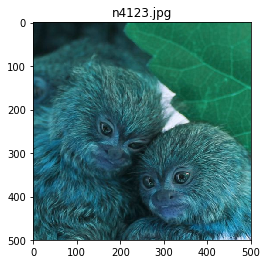

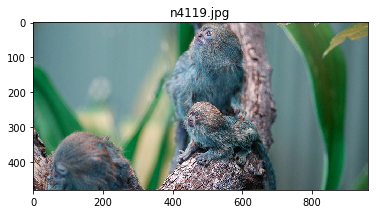

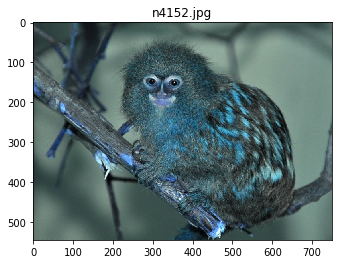

In [12]:
print(labels[4])
image_show(3,'n4')

In [14]:
LR = 1e-3
height=150
width=150
channels=3
seed=1337
batch_size = 64
num_classes = 10
epochs = 200
data_augmentation = True
num_predictions = 20

# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples 

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [16]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 64)        18496     
__________

In [17]:
filepath=str(os.getcwd()+"/model.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

In [18]:
history = model.fit(train_generator,
                    steps_per_epoch=train_num//batch_size
                    epochs=30,
                    validation_data=train_generator,
                    validation_steps=validation_num//batch_size,
                    callbacks=callbacks_list
                    verbose=1
                    )

SyntaxError: invalid syntax (<ipython-input-18-c1ab86d2c14b>, line 3)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
preds = model.predict(test_features)

In [ ]:
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]

In [ ]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

In [ ]:
cm = confusion_matrix(y_pred=predictions, y_true=y_true)
plot_confusion_matrix(cm, normalize=True, target_names=labels)

In [19]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

Epoch 1/200
17/17 [==============================] - 57s 3s/step - loss: 2.2951 - acc: 0.1316 - val_loss: 2.1497 - val_acc: 0.2422

Epoch 00001: val_acc improved from -inf to 0.24219, saving model to /kaggle/working/model.h5f
Epoch 2/200
17/17 [==============================] - 40s 2s/step - loss: 2.0453 - acc: 0.2623 - val_loss: 1.8209 - val_acc: 0.3086

Epoch 00002: val_acc improved from 0.24219 to 0.30859, saving model to /kaggle/working/model.h5f
Epoch 3/200
17/17 [==============================] - 39s 2s/step - loss: 1.8727 - acc: 0.3086 - val_loss: 1.7344 - val_acc: 0.3672

Epoch 00003: val_acc improved from 0.30859 to 0.36719, saving model to /kaggle/working/model.h5f
Epoch 4/200
17/17 [==============================] - 38s 2s/step - loss: 1.6762 - acc: 0.4001 - val_loss: 1.4857 - val_acc: 0.4883

Epoch 00004: val_acc improved from 0.36719 to 0.48828, saving model to /kaggle/working/model.h5f
Epoch 5/200
17/17 [==============================] - 37s 2s/step - loss: 1.5602 - acc: 

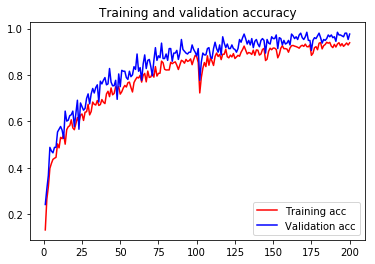

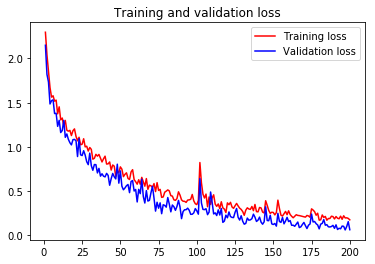

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [22]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

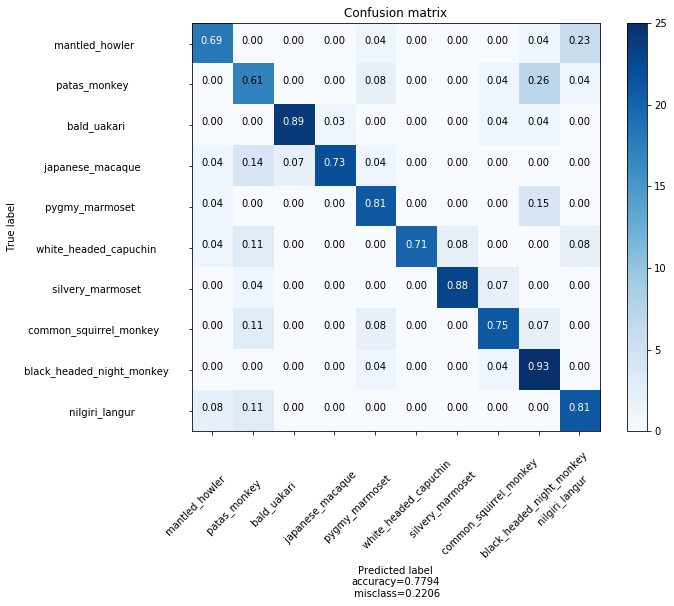

In [23]:
from keras.models import load_model
model_trained = load_model(filepath)
# Predict the values from the validation dataset
Y_pred = model_trained.predict_generator(validation_generator, validation_num // batch_size+1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
#Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = validation_generator.classes,y_pred = Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

In [27]:
print(metrics.classification_report(validation_generator.classes, Y_pred_classes,target_names=labels))

                                 precision    recall  f1-score   support

 mantled_howler                       0.78      0.69      0.73        26
 patas_monkey                         0.55      0.61      0.58        28
 bald_uakari                          0.92      0.89      0.91        27
 japanese_macaque                     0.96      0.73      0.83        30
 pygmy_marmoset                       0.75      0.81      0.78        26
 white_headed_capuchin                1.00      0.71      0.83        28
 silvery_marmoset                     0.92      0.88      0.90        26
 common_squirrel_monkey               0.81      0.75      0.78        28
 black_headed_night_monkey            0.62      0.93      0.75        27
 nilgiri_langur                       0.70      0.81      0.75        26

                    avg / total       0.80      0.78      0.78       272



In [29]:
test_list = os.listdir("../input/10-monkey-species/validation")
test_list.sort()
print(test_list)
model_test = load_model(filepath)

FileNotFoundError: [Errno 2] No such file or directory: '../input/10-monkey-species/validation'

In [26]:
# Import relevant libraries

import torch
import jovian
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

from PIL import Image
import glob

ModuleNotFoundError: No module named 'jovian'

In [ ]:
# Hyperparameters
batch_size = 16
learning_rate = 1e-3

jovian.reset()
jovian.log_hyperparams(batch_size=batch_size, learning_rate=learning_rate)

In [ ]:
# Load image and convert image to multidimensional array
def image_to_array(images_folder):
    dataset = []
    for i in range(10):
        for filename in glob.glob(images_folder + "/n{}/*.jpg".format(i)):
            im = Image.open(filename)
            im = im.resize((400,300))
            pixels = np.asarray(im).astype('float32')
            pixels /= 255.0
            pixels = torch.from_numpy(pixels)
            dataset.append((pixels, i))
    return dataset

In [ ]:
# View a sample Image
img_tensor, label = train_dataset[0]
print(img_tensor.shape)

plt.imshow(img_tensor)
print('Label:', label)

In [ ]:
# View a sample Image
img_tensor, label = test_dataset[100]
print(img_tensor.shape)

plt.imshow(img_tensor)
print('Label:', label)

In [ ]:
# Training and Validation dataset
val_size = round(0.2*len(train_dataset))
train_size = len(train_dataset) - val_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Verify batch
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

In [ ]:
input_size = 300*400*3
num_classes = len(label_dict)
print("Input Size: ", input_size, "\nNumber of Classes: ", num_classes)

In [ ]:
class MonkeyClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MonkeyClassificationModel()
list(model.parameters())

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history1 = fit(100, learning_rate, model, train_loader, val_loader)
history2 = fit(100, learning_rate/10, model, train_loader, val_loader)
history3 = fit(100, learning_rate/10, model, train_loader, val_loader)
history4 = fit(100, learning_rate/100, model, train_loader, val_loader)
history5 = fit(100, learning_rate/1000, model, train_loader, val_loader)

history = history1 + history2 + history3 + history4 + history5

accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [ ]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

In [ ]:
def predict_image(input_img, model):
    inputs = input_img.unsqueeze(0)
    predictions = model(inputs)
    _, preds  = torch.max(predictions, dim=1)
    return preds[0].item()

In [ ]:
label_dict = {0:"alouattapalliata", 1:"erythrocebuspatas", 2:"cacajaocalvus", 3:"macacafuscata",
             4:"cebuellapygmea", 5:"cebuscapucinus", 6:"micoargentatus", 7:"saimirisciureus",
             8:"aotusnigriceps", 9:"trachypithecusjohnii"}